Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [ ]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [ ]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [55]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden1, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv + layer2_biases)
    shape = hidden2.get_shape().as_list()
    reshape = tf.reshape(hidden2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden3, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [56]:
num_steps = 2001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.127513
Minibatch accuracy: 6.2%
Validation accuracy: 12.1%
Minibatch loss at step 50: 1.525823
Minibatch accuracy: 56.2%
Validation accuracy: 40.4%
Minibatch loss at step 100: 0.827471
Minibatch accuracy: 81.2%
Validation accuracy: 73.4%
Minibatch loss at step 150: 0.835296
Minibatch accuracy: 68.8%
Validation accuracy: 74.7%
Minibatch loss at step 200: 0.390560
Minibatch accuracy: 81.2%
Validation accuracy: 76.2%
Minibatch loss at step 250: 0.421829
Minibatch accuracy: 93.8%
Validation accuracy: 77.5%
Minibatch loss at step 300: 0.503045
Minibatch accuracy: 81.2%
Validation accuracy: 79.5%
Minibatch loss at step 350: 1.261425
Minibatch accuracy: 68.8%
Validation accuracy: 80.4%
Minibatch loss at step 400: 1.111256
Minibatch accuracy: 68.8%
Validation accuracy: 79.4%
Minibatch loss at step 450: 0.783103
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 500: 0.866584
Minibatch accuracy: 68.8%
Validation accuracy: 79.7%
Mi

KeyboardInterrupt: 

### Interactive session, let's find out, what is it doin'?

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    global conv1, conv2, hidden1, hidden2, hidden3, logits
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    shape = hidden2.get_shape().as_list()
    reshape = tf.reshape(hidden2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    logits = tf.matmul(hidden3, layer4_weights) + layer4_biases
    return logits
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 10

session = tf.InteractiveSession(graph=graph)

tf.initialize_all_variables().run()
print('Initialized')
for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [ ]:
with graph.as_default():
    #conv1 = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    #hidden1 = tf.nn.relu(conv1 + layer1_biases)
    max_pool = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden1 = tf.nn.relu(max_pool + layer1_biases)
mp = max_pool.eval()
hd = hidden1.eval()

In [ ]:
print("Convolution 1 shape:", conv1.get_shape())
print("Hidden 1 shape:", hidden1.get_shape())
print("Convolution 2 shape:", conv2.get_shape())
print("Hidden 2 shape:", hidden2.get_shape())
print("Hidden 3 shape:", hidden3.get_shape())

In [ ]:
lg = layer4_weights.eval()
print(lg[:,:])

In [ ]:
del img
import matplotlib.pyplot as plt
%matplotlib inline
cnv1 = conv2.eval();
ind = 11
i = 0
for i in xrange(depth):
    img = cnv1[ind,:,:,i]
    img=img.reshape((-1,7))
    plt.figure(figsize=(1,1),frameon=False)
    plt.imshow(img)
    i=i+1

In [ ]:
session.close()

## Let's debug max_pool issues.
tried to cut off tail of test dataset. This is a memory issue.

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

test_dataset = test_dataset[:5000,:,:,:]
test_labels = test_labels[:5000]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    global conv1, conv2, max_pool1, hidden1, hidden2, hidden3, logits
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    max_pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden1 = tf.nn.relu(max_pool1 + layer1_biases)
    conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    shape = hidden2.get_shape().as_list()
    reshape = tf.reshape(hidden2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    logits = tf.matmul(hidden3, layer4_weights) + layer4_biases
    return logits
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 10

session = tf.InteractiveSession(graph=graph)

tf.initialize_all_variables().run()
print('Initialized')
for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

def its_my_plot(xy_list, title='Accurancy or loss',ylabel='Acc or loss'):
#It's my plot with blackjack and whores
    for i in xrange(len(xy_list)):
        plt.plot(xy_list[i][0][:,0], xy_list[i][0][:,1], label=xy_list[i][1])

    plt.xlabel('steps')
    plt.ylabel(ylabel)

    plt.title(title)

    plt.legend()

    plt.show()
    y = np.empty(shape=[41,2])
#example of it's my plot:
#xy_list = [[np.empty(shape=[41,2]),'1']]
#xy_list.append([np.empty(shape=[2001//20,2]),'2'])

#for i in xrange(0,2001//50):
#    xy_list[0][0][i,0]=i
#    xy_list[0][0][i,1]=i=(i**2)*50*2
#for i in xrange(0,(2001//20)):
#    xy_list[1][0][i,0]=i
#    xy_list[1][0][i,1]=i=(i**2)*50
#its_my_plot(xy_list,'Smth')

In [44]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

cutoff = 5000
valid_dataset = valid_dataset[:cutoff,:,:,:]
valid_labels = valid_labels[:cutoff,:]
test_dataset = test_dataset[:cutoff,:,:,:]
test_labels = test_labels[:cutoff,:]

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)
Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (18724, 28, 28, 1) (18724, 10)


In [79]:

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

num_steps = 1001
start_l_rate = 0.10
end_l_rate = 0.01
l2_coef_np = np.float32(0.001)
keep_prop = 1

graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  l2_coef = tf.constant(l2_coef_np)
  keep_prop_1w = tf.constant(keep_prop)
  keep_prop_2w = tf.constant(keep_prop)
  keep_prop_3w = tf.constant(keep_prop)
  keep_prop_4w = tf.constant(keep_prop)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(start_l_rate, global_step, num_steps,end_l_rate,staircase=False)
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    max_pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden1 = tf.nn.relu(max_pool1 + layer1_biases)
    conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    shape = hidden2.get_shape().as_list()
    reshape = tf.reshape(hidden2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    logits = tf.matmul(hidden3, layer4_weights) + layer4_biases
    return logits
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) 
    + l2_coef*tf.nn.l2_loss(layer1_weights) + l2_coef*tf.nn.l2_loss(layer2_weights)
    + l2_coef*tf.nn.l2_loss(layer3_weights) + l2_coef*tf.nn.l2_loss(layer4_weights))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 20 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [4]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

def its_my_plot(xy_list,label_list,y_offset=1, title='Accurancy or loss',ylabel='Acc or loss'):
#It's my plot with blackjack and whores
    if len(label_list)==0:
        label_list = [' ']*len(xy_list)
    if len(label_list)<len(xy_list):
        for i in xrange(len(label_list),len(xy_list)):
            label_list.append(' ')
    fig = plt.figure(1)
    plt.subplots_adjust(left=0.0, right=2.5, bottom=0.0, top=2.5)
    ax = fig.add_subplot(111)
    for i in xrange(len(xy_list)):
        try:
            plt.plot(xy_list[i][:,0], xy_list[i][:,y_offset], label=label_list[i])
        except IndexError as e:
            if xy_list[i].shape[1]<=(1+y_offset):
                print('No such y_offset!')
            else:
                raise
    plt.xlabel('steps')
    plt.ylabel(ylabel)

    plt.title(title)

    #plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))
    ax.grid('on')

    plt.show()
    y = np.empty(shape=[41,2])
#example of it's my plot:
def mpltst(): #testf
    xy_list = [np.zeros(shape=[2001//50,2])]
    xy_list.append(np.zeros(shape=[2001//20,2]))

    for i in xrange(0,2001//50):
        xy_list[0][i,0]=i
        xy_list[0][i,1]=i=(i**2)*50*2
    for i in xrange(0,(2001//20)):
        xy_list[1][i,0]=i
        xy_list[1][i,1]=i=(i**2)*50
    its_my_plot(xy_list,['1','2'],1,'Smth')
#mpltst()

In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

cutoff = 5000
valid_dataset = valid_dataset[:cutoff,:,:,:]
valid_labels = valid_labels[:cutoff,:]
test_dataset = test_dataset[:cutoff,:,:,:]
test_labels = test_labels[:cutoff,:]

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)
Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (18724, 28, 28, 1) (18724, 10)


In [10]:
#let;s try to restore our plots
import pickle

def xy_load(xy_filename):
    global xy_list, label_list
    try:
        with open(xy_filename,'rb') as f:
            xy_list, label_list = pickle.load(f)
    except:
        print('Cant find file %s' % xy_filename)
def xy_del():
    try:
        global xy_list, label_list
        del xy_list, label_list
        print('xy_list deleted!')
    except:
        print('there is already no xy_list!')    
def xy_save(xy_filename):
    # Saving plots
    global xy_list, label_list
    with open(xy_filename, 'wb') as f:
        pickle.dump([xy_list,label_list], f)

Cant find file xy_batch_size_v4.pickle
i=0
Test accuracy: 89.5%
i=1
Test accuracy: 89.0%
i=2
Test accuracy: 88.9%
i=3
Test accuracy: 89.2%
i=4
Test accuracy: 89.2%


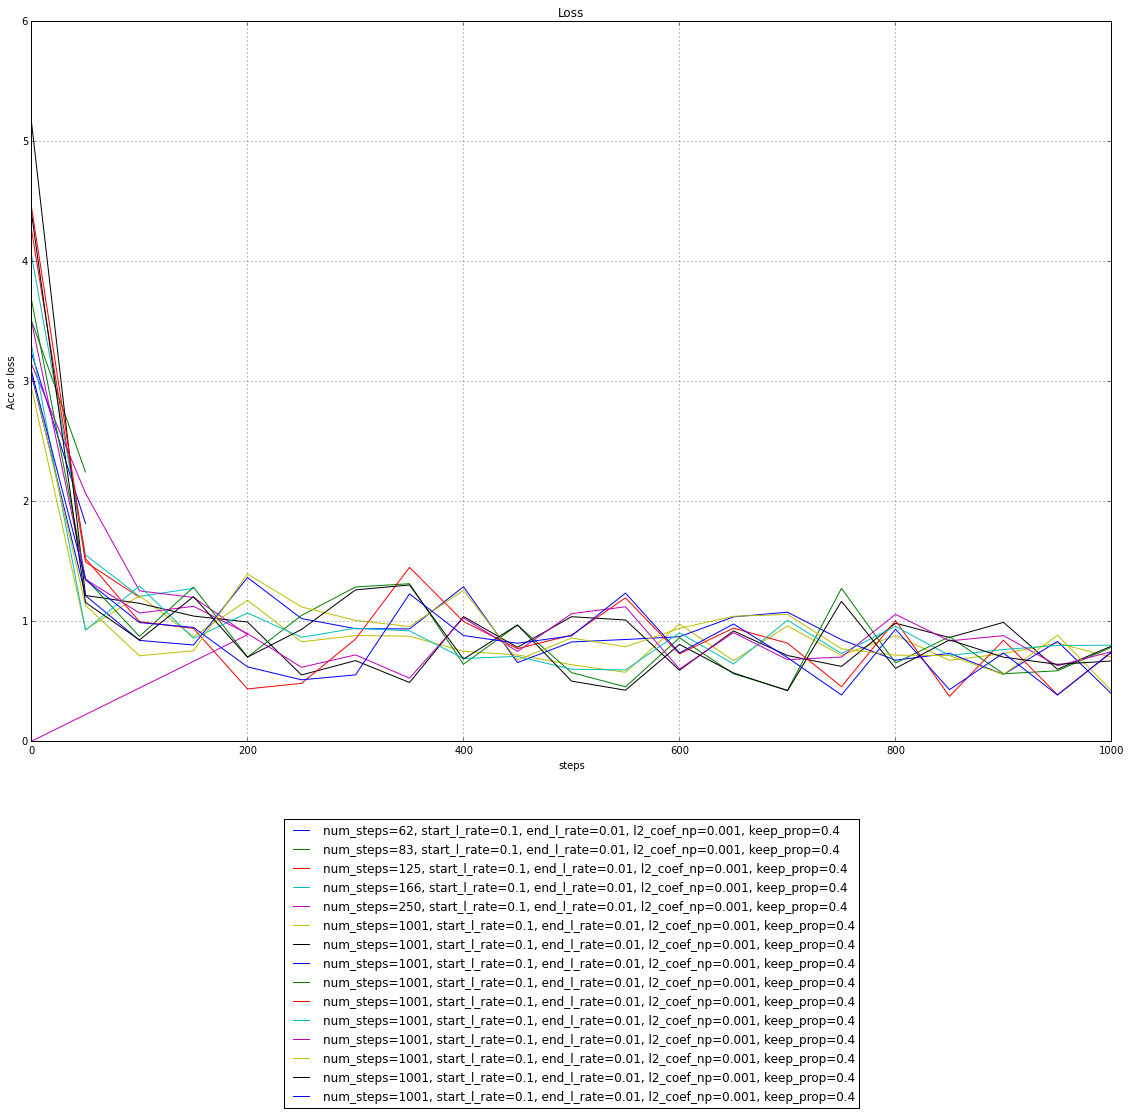

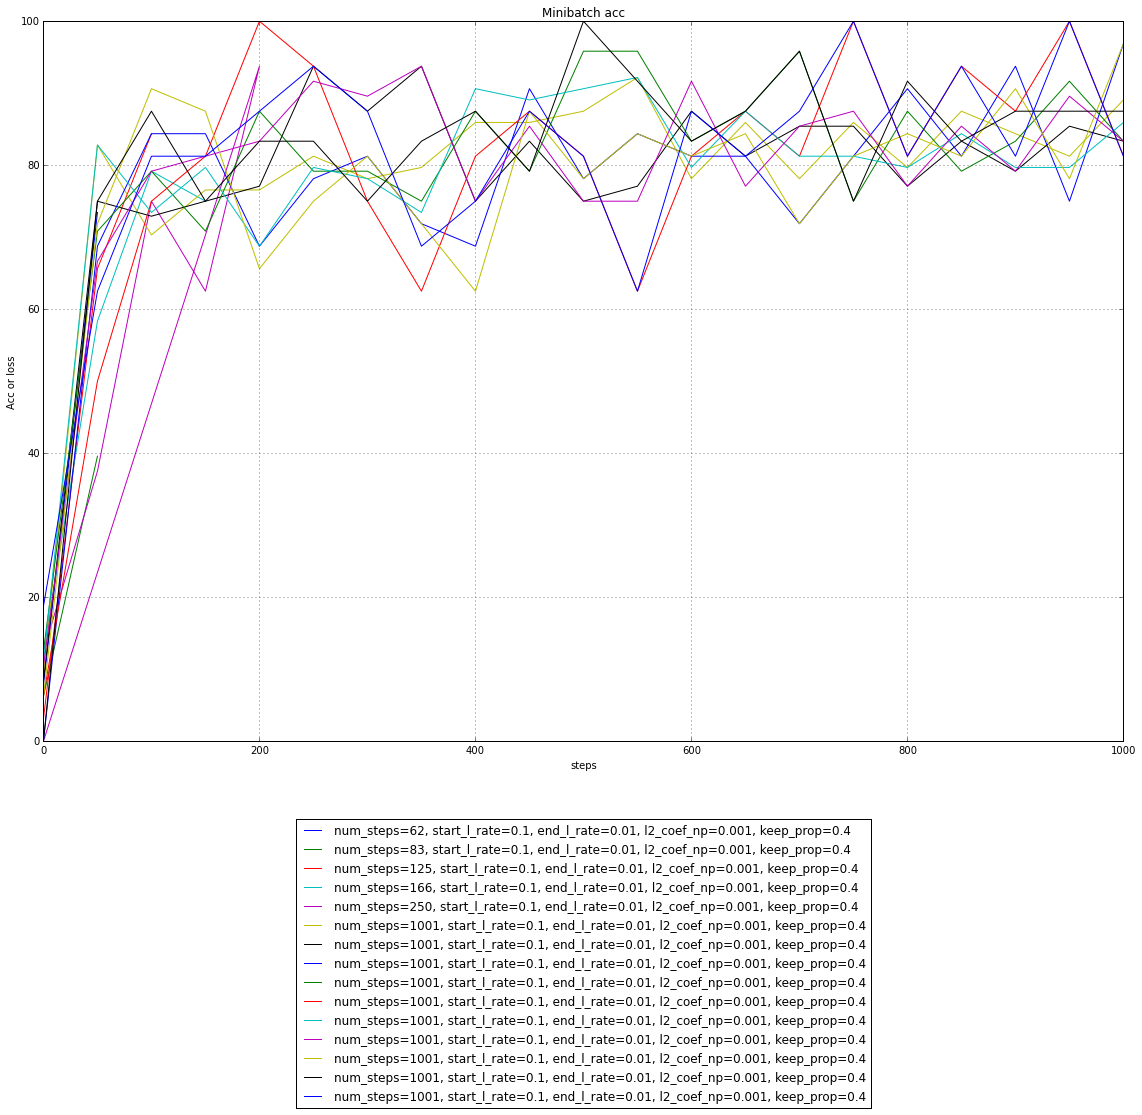

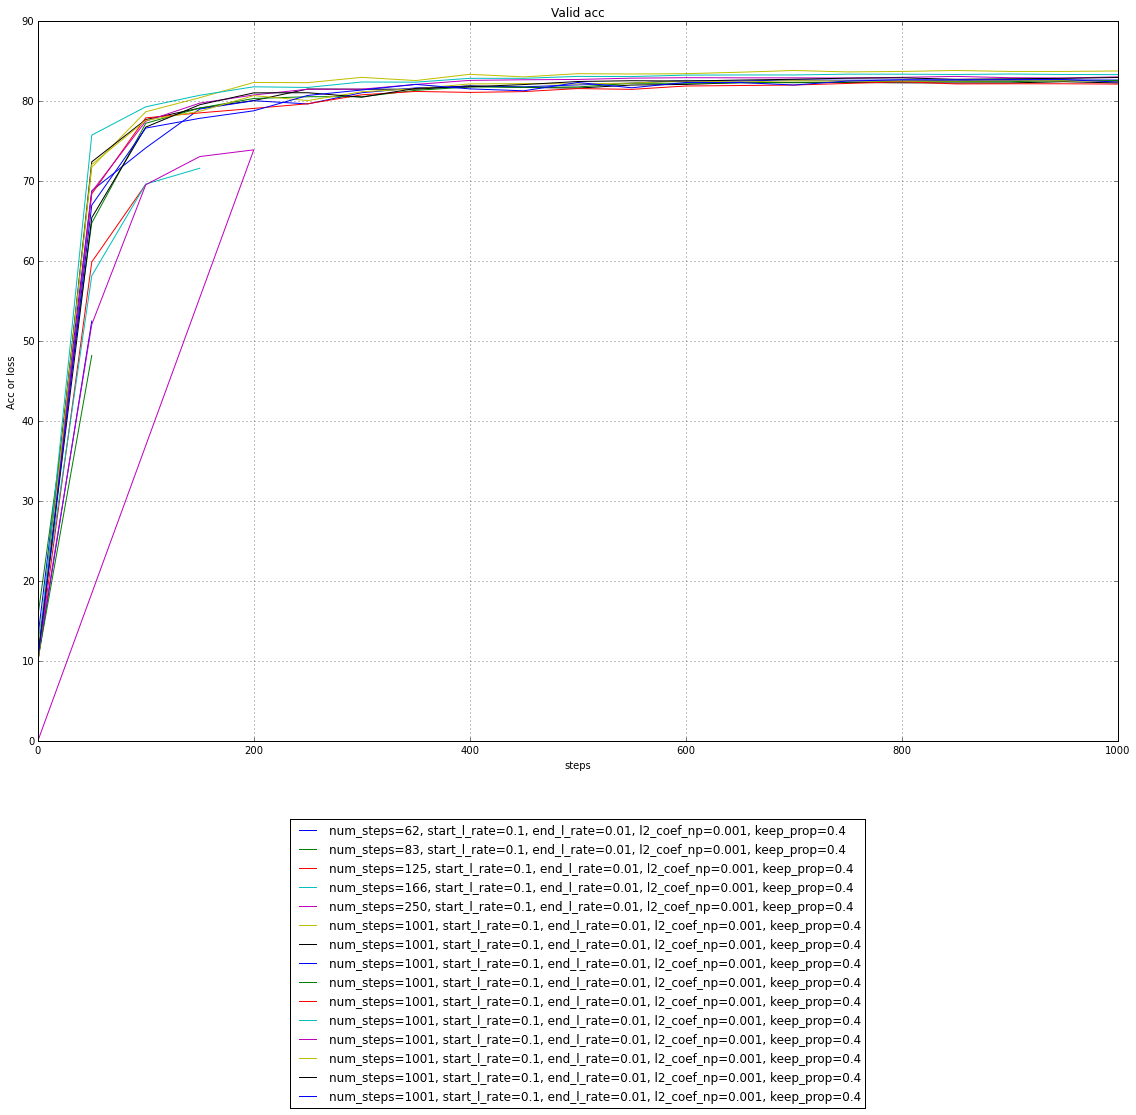

No such y_offset!
No such y_offset!
No such y_offset!
No such y_offset!
No such y_offset!


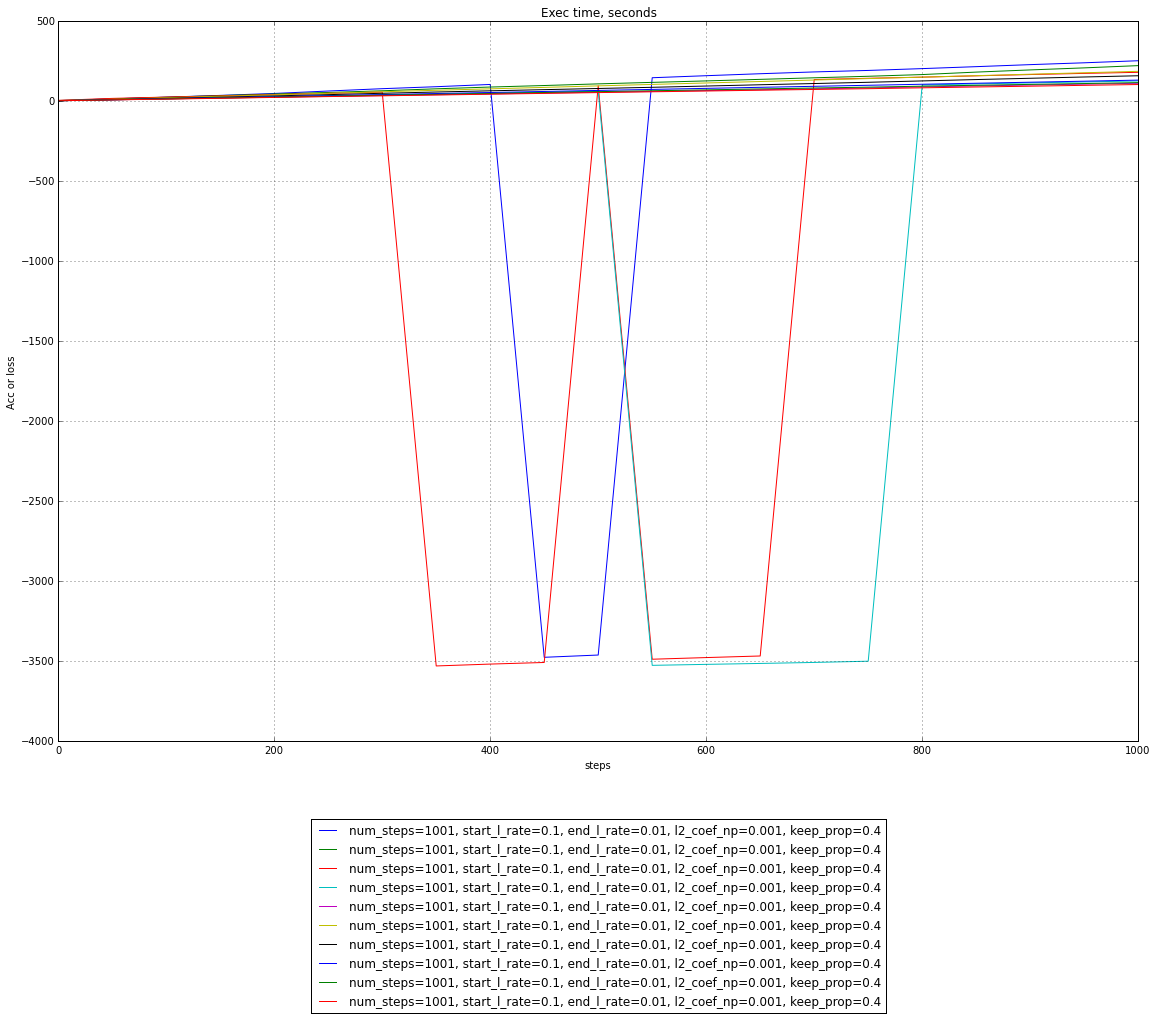

index=0 For parameters num_steps=62, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 57.4%
index=1 For parameters num_steps=83, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 56.1%
index=2 For parameters num_steps=125, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 76.2%
index=3 For parameters num_steps=166, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 78.3%
index=4 For parameters num_steps=250, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 81.4%
index=5 For parameters num_steps=1001, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 90.2%
index=6 For parameters num_steps=1001, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accuracy: 89.4%
index=7 For parameters num_steps=1001, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4
Test accurac

In [7]:
class ConvNet:
    def __init__(self):
        s = self
        s.batch_size = 16
        s.patch_size = 5
        s.depth = 16
        s.num_hidden = 64

        s.num_steps = 1001
        s.start_l_rate = 0.10
        s.end_l_rate = 0.01
        s.l2_coef_np = np.float32(0.001)
        s.keep_prop = 1
        
        s.plot_every = 50
    def set_koefs(self, batch_size = 16,
                  patch_size = 5, depth = 16, num_hidden = 64,
                  num_steps = 1001, start_l_rate = 0.10, end_l_rate = 0.01,
                  l2_coef_np = np.float32(0.001), keep_prop = 1,plot_every=50):
        """ ObjConvNet.set_koefs(batch_size = 16,
                   patch_size = 5, depth = 16, num_hidden = 64,
                   num_steps = 1001, start_l_rate = 0.10, end_l_rate = 0.01,
                   l2_coef_np = np.float32(0.001), keep_prop = 1,plot_every=50)"""
        s = self
        s.batch_size = batch_size
        s.patch_size = patch_size
        s.depth = depth
        s.num_hidden = num_hidden

        s.num_steps = num_steps
        s.start_l_rate = start_l_rate
        s.end_l_rate = end_l_rate
        s.l2_coef_np = np.float32(l2_coef_np)
        s.keep_prop = keep_prop
        s.plot_every = plot_every
    def lbl(self):
        s = self
        lbl = ('batch_size='+str(s.batch_size)+', patch_size='+str(s.patch_size)
            +', depth='+str(s.depth)+', num_hidden='+str(s.num_hidden)
            +', num_steps='+str(s.num_steps)+', start_l_rate='+str(s.start_l_rate)
            +', end_l_rate='+str(s.end_l_rate)+', l2_coef_np='+str(s.l2_coef_np)+', keep_prop='+str(s.keep_prop))
        return lbl
    def init_graph(self):
        s = self
        s.graph = tf.Graph()
        with s.graph.as_default():

          # Input data.
          s.tf_train_dataset = tf.placeholder(
            tf.float32, shape=(s.batch_size, image_size, image_size, num_channels))
          s.tf_train_labels = tf.placeholder(tf.float32, shape=(s.batch_size, num_labels))
          s.tf_valid_dataset = tf.constant(valid_dataset)
          s.tf_test_dataset = tf.constant(test_dataset)
          s.l2_coef = tf.constant(s.l2_coef_np)
          s.keep_prop_1w = tf.constant(s.keep_prop)
          s.keep_prop_2w = tf.constant(s.keep_prop)
          s.keep_prop_3w = tf.constant(s.keep_prop)
          s.keep_prop_4w = tf.constant(s.keep_prop)

          # Variables.
          s.layer1_weights = tf.Variable(tf.truncated_normal(
              [s.patch_size, s.patch_size, num_channels, s.depth], stddev=0.1))
          s.layer1_biases = tf.Variable(tf.zeros([s.depth]))
          s.layer2_weights = tf.Variable(tf.truncated_normal(
              [s.patch_size, s.patch_size, s.depth, s.depth], stddev=0.1))
          s.layer2_biases = tf.Variable(tf.constant(1.0, shape=[s.depth]))
          s.layer3_weights = tf.Variable(tf.truncated_normal(
              [image_size // 4 * image_size // 4 * s.depth, s.num_hidden], stddev=0.1))
          s.layer3_biases = tf.Variable(tf.constant(1.0, shape=[s.num_hidden]))
          s.layer4_weights = tf.Variable(tf.truncated_normal(
              [s.num_hidden, num_labels], stddev=0.1))
          s.layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

          s.global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
          s.learning_rate = tf.train.exponential_decay(s.start_l_rate,
                                                       s.global_step, s.num_steps,s.end_l_rate,staircase=False)

          # Model.
          def model(self, data):
            s = self
            conv1 = tf.nn.conv2d(data, s.layer1_weights, [1, 1, 1, 1], padding='SAME')
            max_pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            hidden1 = tf.nn.relu(max_pool1 + s.layer1_biases)
            conv2 = tf.nn.conv2d(hidden1, s.layer2_weights, [1, 2, 2, 1], padding='SAME')
            hidden2 = tf.nn.relu(conv2 + s.layer2_biases)
            shape = hidden2.get_shape().as_list()
            reshape = tf.reshape(hidden2, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden3 = tf.nn.relu(tf.matmul(reshape, s.layer3_weights) + s.layer3_biases)
            logits = tf.matmul(hidden3, s.layer4_weights) + s.layer4_biases
            return logits
          s.model = model

          # Training computation.
          s.logits = s.model(s,s.tf_train_dataset)
          s.loss = (tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(s.logits, s.tf_train_labels)) 
            + s.l2_coef*tf.nn.l2_loss(s.layer1_weights) + s.l2_coef*tf.nn.l2_loss(s.layer2_weights)
            + s.l2_coef*tf.nn.l2_loss(s.layer3_weights) + s.l2_coef*tf.nn.l2_loss(s.layer4_weights))

          # Optimizer.
          s.optimizer = tf.train.GradientDescentOptimizer(s.learning_rate).minimize(s.loss, global_step=s.global_step)

          # Predictions for the training, validation, and test data.
          s.train_prediction = tf.nn.softmax(s.logits)
          s.valid_prediction = tf.nn.softmax(s.model(s,s.tf_valid_dataset))
          s.test_prediction = tf.nn.softmax(s.model(s,s.tf_test_dataset))
    def run_graph(self):
        s = self
        with tf.Session(graph=s.graph) as session:
          global xy_list, label_list
          
          leng = s.num_steps//s.plot_every + 1
          try:
              xy_list.append(np.empty(shape=[leng,6]))
              label_list.append(s.lbl())
          except (NameError, AttributeError) as e:
              xy_list = [np.empty(shape=[leng,6])]
              label_list = [ lbl ]
          tf.initialize_all_variables().run()
          #print('Initialized')
          j = 0
          start_time = timer() #timeit
          for step in range(s.num_steps):
            offset = (step * s.batch_size) % (train_labels.shape[0] - s.batch_size)
            batch_data = train_dataset[offset:(offset + s.batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + s.batch_size), :]
            feed_dict = {s.tf_train_dataset : batch_data, s.tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [s.optimizer, s.loss, s.train_prediction], feed_dict=feed_dict)
            
            if (step % s.plot_every == 0):
              xy_list[-1][j,0] = step
              xy_list[-1][j,2] = l
              #print('Minibatch loss at step %d: %f' % (step, l))
              xy_list[-1][j,3] = accuracy(predictions, batch_labels)
              #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
              #print('Validation accuracy: %.1f%%' % accuracy(
              #  s.valid_prediction.eval(), valid_labels))
              xy_list[-1][j,1]=accuracy(s.valid_prediction.eval(), valid_labels)
              #print('Validation accuracy: %.1f%%' % xy_list[-1][j,1])
              xy_list[-1][j,5] = timer()-start_time
              #print('Execution time %.1f%%' % xy_list[-1][j,5])
              j = j+1
          xy_list[-1][-1,4] = accuracy(s.test_prediction.eval(), test_labels)
          print('Test accuracy: %.1f%%' % xy_list[-1][-1,4])

       
xy_filename = 'xy_batch_size_v4.pickle'
xy_del()
xy_load(xy_filename)

#defining change list
ch_list = [64, 48, 32, 24, 16 ]
for i in xrange(len(ch_list)):
    print('i='+str(i))
    cnn = ConvNet()
    #""" ObjConvNet.set_koefs(batch_size = 16,
    #               patch_size = 5, depth = 16, num_hidden = 64,
    #               num_steps = 1001, start_l_rate = 0.10, end_l_rate = 0.01,
    #               l2_coef_np = np.float32(0.001), keep_prop = 1,plot_every=50)"""
    cnn.set_koefs(ch_list[i],5,16,64,1001,0.1,0.01,0.001,0.4,50)
    cnn.init_graph()
    cnn.run_graph()
    del cnn
#xy_list y_offset 's:
#0 - step, 1 - valid, 2 - loss, 3 - minibatch, 4 - test(in the last cell), 5 - exec time
its_my_plot(xy_list,label_list,2,'Loss')
its_my_plot(xy_list,label_list,3,'Minibatch acc')
its_my_plot(xy_list,label_list,1,'Valid acc')
its_my_plot(xy_list,label_list,5,'Exec time, seconds')
for i in xrange(len(xy_list)):
    try:
        print('index='+str(i)+' For parameters',label_list[i])
        print('Test accuracy: %.1f%%' % xy_list[i][-1,4])
    except:
        pass

xy_save(xy_filename)
    

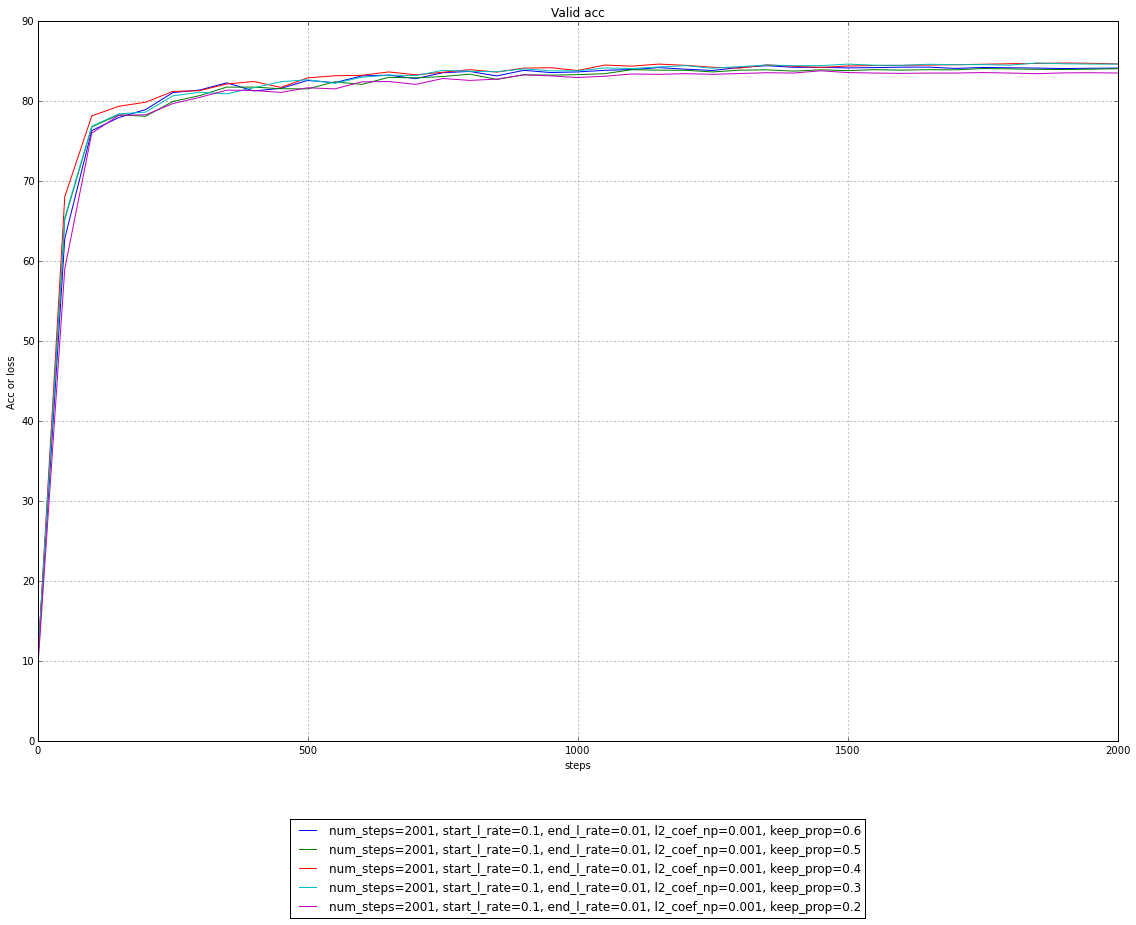

In [79]:
its_my_plot(xy_list[4:],label_list[4:],0,'Valid acc')

In [3]:
xy_filename = 'xy_batch_size_vf.pickle'
xy_load(xy_filename)
for i in xrange(len(xy_list)):
    try:
        print('index='+str(i)+' For parameters',label_list[i])
        print('Test accuracy: %.1f%%' % xy_list[i][-1,4])
    except:
        pass

('index=0 For parameters', 'num_steps=62, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 57.4%
('index=1 For parameters', 'num_steps=83, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 56.1%
('index=2 For parameters', 'num_steps=125, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 76.2%
('index=3 For parameters', 'num_steps=166, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 78.3%
('index=4 For parameters', 'num_steps=250, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 81.4%
('index=5 For parameters', 'num_steps=1001, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 90.2%
('index=6 For parameters', 'num_steps=1001, start_l_rate=0.1, end_l_rate=0.01, l2_coef_np=0.001, keep_prop=0.4')
Test accuracy: 89.4%
('index=7 For parameters', 'num_steps=1001, start_l_rate=0.1, end_l_r

In [94]:
del xy_list,label_list

In [12]:
xy_del()

there is already no xy_list!
